In [ ]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=1)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.0
Using accelerate v0.16.0
Using sentencepiece v0.1.97
Using sacremoses v0.0.41


#트랜스포머 아키텍처
원본 트랜스포머는 인코더 - 디코드 구조를 기반으로 한다. 해당 구조는 단어의 시퀀스를 다른 언어로 번역하는 기계 번역 같은 작업에 널리 사용된다.

## 인코더
입력 토큰의 시퀀스를 은닉 상태(Hidden state) 또는 문맥(Context)이라 부르는 임베딩 벡터의 시퀀스로 변환한다.

## 디코더
인코더의 은닉 상태를 사용해 출력 토큰의 시퀀스를 한 번에 하나씩 반복적으로 생성한다.
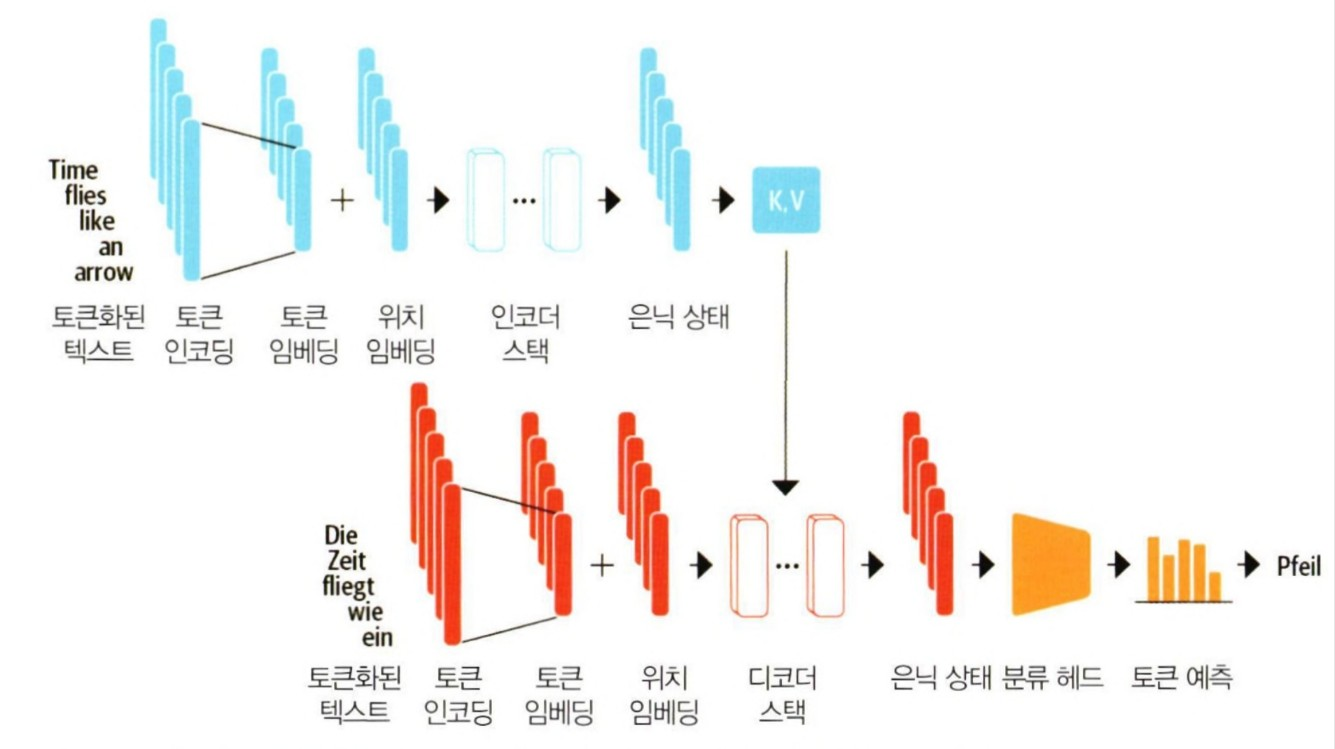



- 입력 텍스트를 토큰화하고 토큰 임베딩으로 변환한다. 어텐션 메커니즘은 토큰의 상대적인 위치를 알지 못하기에, 텍스트의 순서 특징을 모델링하기 위해 입력에 토큰 위치에 관한 정보를 주입해야 한다. 이를 위해 각 토큰의 위치 정보가 담긴 위치 임베딩을 토큰 임베딩과 합친다.  
- 인코더가 인코더 층의 스택 또는 '블록'으로 구성되는데, 이는 cv에서 합성곱 층의 스택과 유사하다. 디코더도 마찬가지로 디코더 층의 스택으로 구성된다.
- 디코더 층마다 인코더의 출력이 주입된다. 디코더는 시퀀스에서 가장 가능성 있는 다음 토큰을 예측한다. 이 단계의 출력이 디코더로 다시 주입되어 다음 토큰을 생성한다. 이런 과정이 특수한 EOS(End-Of-Sequence) 토큰에 도달할 때까지 계속된다.  
Ex) 위 그림에서 디코더가 이미 'Die'와 'Zeit'를 예측했다고 가정해보자. 디코더는 이제 두 토큰은 물론 인코더의 출력을 입력으로 사용해 다음 토큰 'fliegt'를 예측한다. 다음 단계에서 디코더는 'fliegt'를 추가적인 입력으로 사용한다. 디코더가 EOS 토큰을 예측하거나 최대 길이에 도달할 때까지 이 과정을 반복한다.

트랜스포머 모델이 수백 개나 되지만, 대부분 세 유형으로 나뉜다.


## 인코더 유형
이 모델은 텍스트 시퀀스 입력을 풍부한 수치 표현으로 변환한다. 이 표현은 텍스트 분류나 개체명 인식 같은 작업에 잘 맞다. BERT를 비롯해 RoBERTa나 DistilBERT같은 BERT 변종이 이 유형의 아키텍처이다. 이런 아키텍처에서 한 토큰에 대해 계산한 표현은 왼쪽(이전 토큰)과 오른쪽(이후 토큰)문맥에 따라 달라진다. 이를 종종 ```양방향 어텐션```이라고 부른다.

## 디코더 모형
이 모델은 "Thanks for lunch, I had a ..."와 같은 시작 텍스트가 주어지면 가장 가능성 있는 다음 단어를 반복해 예측하는 식으로 시퀀스를 자동 완성한다. GPT 계열의 모델이 이 유형에 해당한다. 이런 아키텍처에서 한 토큰에 대해 계산한 표현은 오직 왼쪽 문맥에 따라 달라진다. 이를 종종 ```코잘 어텐션(Causal attention)``` 또는 ```자기회귀 어텐션(Autoregressive attention)```이라고 부른다.

## 인코더 - 디코더 유형
한 텍스트의 시퀀스를 다른 시퀀스로 매핑하는 복잡한 모델링에 사용한다. 따라서 기계 번역과 요약 작업에 적합하다. 인코더와 디코더를 연결한 트랜스포머 아키텍처 외에 BERT와 T5 모델이 이 유형에 속한다.

# 인코더
위에서 보았듯 트랜스포머 인코더는 여러 개의 인코더 층이 서로 쌓여 구성된다. 각 인코더 층은 임베딩 시퀀스를 받아 다음과 같은 층을 통과시킨다.
- 멀티 헤드 셀프 어텐션 층
- 각각의 입력 임베딩에 적용되는 완전 연결 피드 포워드 층  

인코더 층의 출력 임베딩은 입력과 크기가 동일하다. 인코더 스택의 주요 역할은 입력 임베딩을 업데이트해 시퀀스의 문맥 정보가 인코딩된 표현을 만드는 것이다.

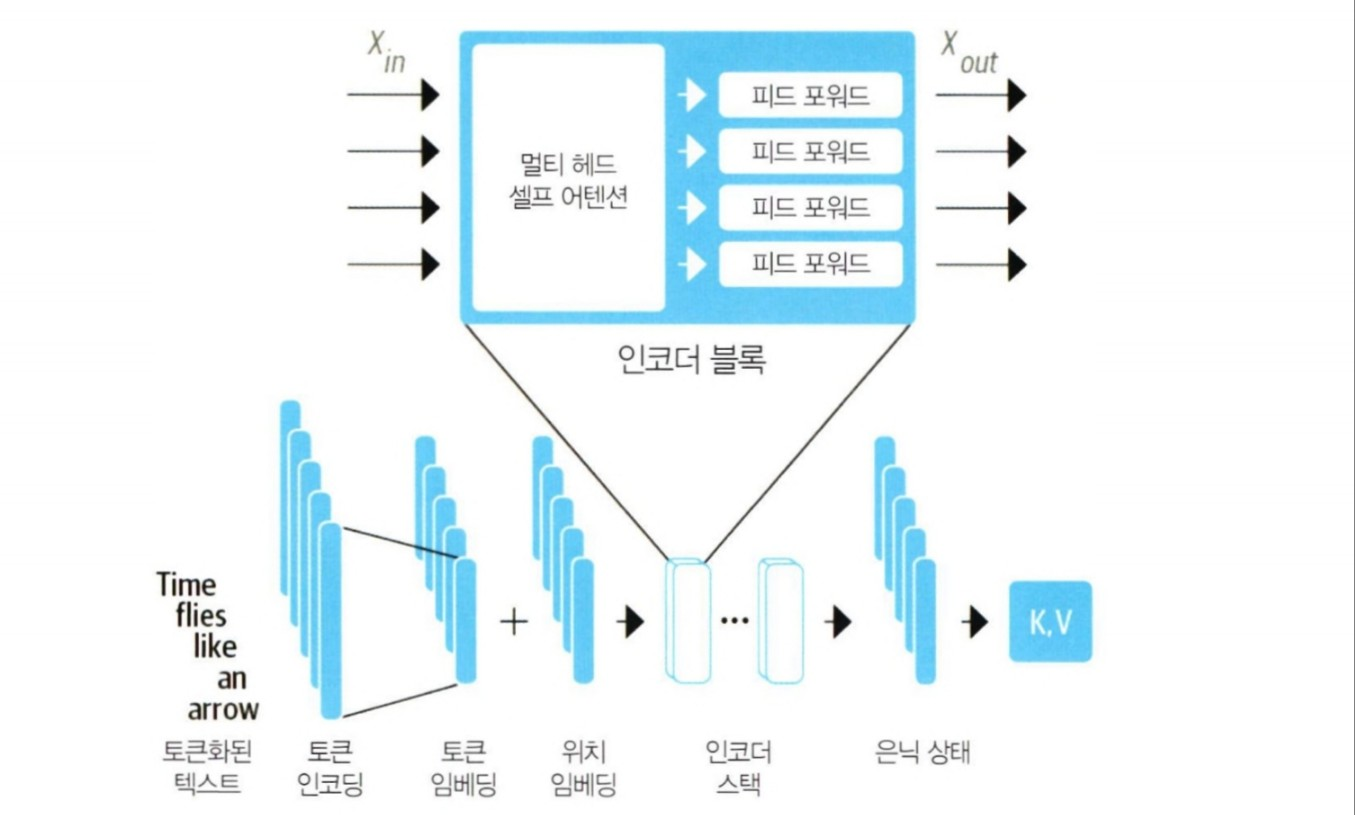

멀티 헤드 어텐션 층과 피드 포워드 층은 심층 신경망을 효율적으로 훈련하기 위해 표준 기법인 스킵 연결(skip connection)과 층 정규화(layer normalization)도 사용한다. 가장 중요한 구성 요소인 셀프 어텐션 층부터 시작해보자.

## 셀프 어텐션
어텐션 메커니즘을 사용하면 신경망이 시퀀스의 각 원소에 다른 양의 가중치 또는 '어텐션'을 할당한다. 텍스트 시퀀스에서 원소는 2장에서 본 토큰 임베딩이다. 각 토큰은 고정 차원의 벡터에 매핑된다. (예를 들어 BERT에서 각 토큰은 768차원 벡터로 표현된다.) 셀프 어텐션의 '셀프'는 이 가중치가 동일 집합에 있는 모든 은닉 상태(ex. 인코더의 모든 은닉 상태)에 대해 계산된다는 사실을 나타낸다. 반면, 순환 모델과 연관된 어텐션 메커니즘은 특정 디코딩 타임스텝에서 해당 디코더의 은닉 상태와 인코더의 각 은닉 상태가 가진 관련성을 계산한다.

### 스케일드 점곱 어텐션
셀프 어텐션 층을 구현하는 여러 방법 중 트랜스포머 아키텍처를 소개한 논문에서 다룬 스케일드 점곱 어텐션(Scaled dot-product attention)이 가장 일반적이다. 이 메커니즘은 네 단계로 구성된다.
- 각 토큰 임베딩을 쿼리(query), 키(key), 값(value) 세 개의 벡터로 투영한다.
- 어텐션 점수를 계산한다. 유사도 함수를 사용해 쿼리 벡터와 키 벡터가 서로 얼마나 관련있는지 계산한다. 이 때 유사도 함수는 내적으로 되어있으며, 임베딩의 행렬 곱셈을 사용해 효율적으로 계산한다. 쿼리와 키가 비슷하면 내적 결과가 크고, 쿼리와 키에 공통 부분이 많지 않으면 겹치는 부분이 적거나 거의 없으므로 내적 결과가 작다. 이 단계의 출력을 어텐션 점수라고 하며, n개의 입력 토큰이 있는 시퀀스의 경우 크기가 n x n인 어텐션 점수 행렬이 만들어진다.
- 어텐션 가중치를 계산한다. 일반적으로 내적은 임의의 큰 수를 만들기에 훈련 과정이 불안정하다. 이를 처리하기 위해 먼저 어텐션 점수에 스케일링 인자를 곱해 분산을 정규호하고 소프트맥스 함수를 적용해 모든 열의 합이 1이 되게 한다. 이를 통해 만들어진 n x n 행렬에는 어텐션 가중치 w_ji가 담긴다.
- 토큰 임베딩을 업데이트한다. 어텐션 가중치가 계산되면 이를 값 벡터 v_1, ,,, v_n과 곱해서 임베딩을 위해 업데이트된 표현을 얻는다.

어텐션 가중치가 계산되는 과정을 시각화해보자.  

어텐션 가중치를 시각화하기 위해 neuron_view 모듈을 사용하겠다. 이 모듈은 퀴리와 키 벡터가 어떻게 결합되어 최종 가중치를 생산하는지를 가중치 계산 과정을 추적해 알려준다. BertViz가 모델의 어텐션 층을 활용하므로 BERT 체크포인트로 BertViz의 모델 클래스 객체를 초기화하겠다. 그 다음 show() 함수를 사용해 특정 인코더 층과 어텐션 헤드에 대한 interactive한 시각화를 생성한다. 어텐션 시각화를 시작하려면 왼쪽의 + 기호를 클릭하자.

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 12.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode = "light", layer = 0, head =8)

Output hidden; open in https://colab.research.google.com to view.

Scaled dot-product attention을 계산하는 연산을 다이어그램으로 그려서 해당 과정을 자세히 살펴보자.

In [ ]:
inputs = tokenizer(text, return_tensors = 'pt', add_special_tokens = False) #스페셜 토큰 제외
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

시퀀스에 있는 각 토큰은 토크나이저 어휘사전에서 고유한 각 ID에 매핑된다. 간단하게 하기 위해 add_special_tokens = False로 설정해 [CLS]와 [SEP] 토큰을 제외하겠다. 이후 dense imbedding을 만들자. 여기서 밀집(dense) 임베딩은 모든 원소의 값이 0이 아니라는 의미이다. 이와 달리 2장에서 본 원-핫 인코딩은 sparse한데, 한 원소를 제외한 모든 원소가 0이기 때문이다. 어쨌든, dense imbedding을 만들기 위해 각 입력 ID에 대한 룩업 테이블처럼 동작하는 파이토치의 torch.nn.Embedding 층을 사용하겠다.

In [ ]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

앞 코드에서 AutoConfig 클래스를 사용해 bert-base-uncased 체크포인트에 관련된 config.json 파일을 로드했다. 트랜스포머스에서는 모든 체크포인트는 vocab_size와 hidden_size같은 다양한 하이퍼파라미터가 지정된 설정 파일이 할당된다. 해당 예제의 경우 입력 ID가 nn.Embedding에 저장된 30522개 임베딩 벡터 중 하나에 매핑되고, 각 벡터의 크기는 768이다. AutoConfig 클래스는 모델 예측 포맷을 지정하는데 사용되는 추가적인 메타데이터도 저장한다.  

이 시점에서 토큰 임베딩은 문맥과 독립적이다. 즉 이전 예시의 'flies' 같은 동음이의어의 표현이 동일하다. 이어지는 어텐션 층은 이런 토큰 임베딩을 혼합해 의미를 명확하게 하고 토큰 표현에 문맥 내용을 주입한다.  

이제 룩업 테이블이 준비됐으니 입력 ID를 전달해 임베딩을 만들자.

In [ ]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()
#해당 층은 [batch_size, seq_len, hidden_dim] 크기의 텐서를 출력한다.

torch.Size([1, 5, 768])

다음 단계는 쿼리, 키, 값 벡터를 만들고 점곱을 유사도 함수로 사용해 어텐션 점수를 계산하는 것이다.

In [ ]:
import torch
from math import sqrt

query = key = value = inputs_embeds #5, 768
dim_k = key.size(-1) #768
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k) #bmm : 배치 행렬 곱(Batch Matrix Multiplication, BMM)
scores.size()

torch.Size([1, 5, 5])

배치에 있는 샘플마다 5 x 5 크기의 어텐션 점수 행렬이 만들어졌다. 나중에 임베딩에 독립적인 가중치 행렬 W_q,k,v을 각각 적용해 쿼리, 키, 값 벡터를 생성하겠다. 하지만 여기서는 간단하게 모두의 값을 같게 했다. Scaled dot-producted attention에서 내적은 임베딩 벡터의 크기로 스케일을 조정한다. 이 과정은 훈련 도중 큰 수의 빈번한 발생을 줄여 다음에 이어질 소프트 맥스 함수의 포화를 방지한다.

이제 소프트맥스 함수를 적용해보자.

In [ ]:
import torch.nn.functional as F

weights = F.softmax(scores, dim = -1)
weights.sum(dim = -1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

마지막으로 값에 어텐션 가중치를 곱한다.

In [ ]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

이것으로 끝이다. 간단한 셀프 어텐션을 만드는 단계를 모두 수행하였다. 전 과정이 두 개의 행렬 곱셈과 소프트맥스 함수이니 셀프 어텐션을 일종의 멋진 평균 계산으로 생각해도 좋다.  


나중에 사용하기 위해 해당 단계를 하나의 함수로 만들겠다.

In [ ]:
def scaled_dot_product_attention(query, key, value):
  dim_k = query.size(-1)
  scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
  weight = F.softmax(scores, dim = -1)
  return torch.bmm(weights, value)

동일한 쿼리와 키 벡터를 사용하는 어텐션 메커니즘은 문맥에서 동일한 단어, 특히 현재 읽어들인 단어에 매우 큰 점수를 할당한다. 하지만 실전에서 단어의 의미를 파악하는 데 도움되는 것은 동일한 단어보다 문맥을 보완하는 단어이다. 예를 들어 'flies'의 의미는 중복 언급된 'flies'보다 'time'과 'arrow' 정보를 통합할 때 더 잘 정의된다. 이런 동작은 어떻게 만들어질까??  

세 개의 선형 투영을 사용해 초기 토큰 벡터를 세 개의 공간에 투영하는 식으로, 토큰의 쿼리, 키, 값 벡터를 다르게 만들어보겠다.   

### 멀티 헤드 어텐션  
이 전의 간단한 예에서 임베딩을 있는 그대로 사용해 어텐션 점수와 가중치를 계산했지만, 실제와는 큰 차이가 있다. 실제로 셀프 어텐션 층은 각 임베딩에 독립적인 선형 변환 세 개를 적용해 쿼리, 키, 값 벡터를 생성한다. 이런 변환은 임베딩을 투영하며 각 투영은 학습 가능한 파라미터를 갖는다. 따라서 셀프 어텐션 층은 시퀀스의 다양한 의미에 초점을 맞춘다.  


또 여러 선형 투영이 도움이 된다고 알려졌는데, 각 투영 집합을 어텐션 헤드라고 한다. 이것들을 concat한 것을 멀티 헤드 어텐션 층이라고 한다.  

왜 어텐션 헤드가 하나 이상 필요할까? 한 헤드의 소프트맥스가 유사도의 한 측면에만 초점을 맞추는 경향이 있기 때문이다. 여러 개의 헤드가 있으면 모델은 동시에 여러 측면에 초점을 맞춘다. 예를 들어 한 헤드는 주어 - 동사 상호작용에 초점을 맞추고, 다른 헤드는 인접한 형용사를 찾는 식이다. 이런 관계는 모델에 수동으로 입력되지 않고 모델이 직접 데이터에서 학습한다.

이런 층을 만들기 위해 먼저 어텐션 헤드 하나를 위한 코드를 작성해보자.

In [ ]:
#input_embeds : (1,5,768)
class AttentionHead(nn.Module):
  def __init__(self, embed_dim, head_dim): #768, 64 ,,, 64는 투영하려는 차원의 크기
    super().__init__()
    #세 개의 독립된 선형 층(가중치 행렬) 만들기
    self.q = nn.Linear(embed_dim, head_dim) #768, 64 ,,, [-1/64, 1/64]에서 랜덤하게 뽑혀서 만들어짐
    self.k = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)

  def forward(self, hidden_state): #5, 768
    attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)) #q(hidden_state) : 5, 64
    return attn_outputs

세 개의 독립된 선형 층은 임베딩 벡터에 행렬 곱셈을 적용해 [batch_size, seq_len, head_dim] 크기의 텐서를 만든다. head_dim은 투영하려는 차원의 크기이다. head_dim이 토큰의 임베딩 차원(embed_dim)보다 더 작을 필요는 없으나, 실전에서는 헤드마다 계산이 일정하도록 embed_dim과 배수가 되게 선택한다. 예를 들어 BERT에는 어텐션 헤드가 12개 있으므로 각 헤드의 차원은 768/12 = 64가 된다.  
어텐션 헤드가 준비되었으니 각 헤드의 출력을 연결해서 완전한 멀티 헤드 어텐션 층을 만들자.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    embed_dim = config.hidden_size #임베딩 차원
    num_heads = config.num_attention_heads #어텐션 헤드 수
    head_dim = embed_dim // num_heads
    self.heads = nn.ModuleList( #self.heads(hidden_state)
        [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)] #768, 64
    )
    self.output_linear = nn.Linear(embed_dim, embed_dim)

  def forward(self, hidden_state):
    x = torch.cat([h(hidden_state) for h in self.heads], dim = -1)
    x = self.output_linear(x)
    return x

어텐션 헤드의 출력을 연결한 다음 최종 선형 층으로 주입하여 [batch_size, seq_len, hidden_dim] 크기의 출력 텐서를 만든다. 이 형태는 뒤따르는 피드 포워드 신경망에 사용하기 적절하다. 멀티 헤드 어텐션 층이 기대하는 입력 크기를 만드는지 확인해보자.  
MultiHeadAttention 모듈을 초기화할 때 앞서 사전 훈련된 BERT 모델에서 로드한 설정을 전달한다. 그러면 BERT와 동일한 설정을 사용한다.  

In [ ]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

성공이다!  

BertViz를 다시 사용해서 다른 용도로 사용된 'flies' 단어의 어텐션을 시각화해보자.

## 피드 포워드 층

인코더와

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.gelu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    return x

foward() 함수는 모델이 학습데이터를 입력받아서 forward 연산을 진행시키는 함수입니다. 이 forward() 함수는 model 객체를 데이터와 함께 호출하면 자동으로 실행이됩니다.

In [ ]:
#어텐션 출력 전달 및 테스트
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

완전한 트랜스포머 인코더 층에 필요한 요소를 모두 갖추었다. 남은 일은 스킵 연결과 층 정규화를 배치할 위치를 정하는 것이다. 이 위치가 모델 구조에 어떤 영향을 미치는지 알아보자.

사전 층 정규화를 사용해보자.

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.attention = MultiHeadAttention(config)
    self.feed_forward = FeedForward(config)

  def forward(self, x):
    #층 정규화를 적용하고 입력을 쿼리, 키, 값으로 복사하였다.
    hidden_state = self.layer_norm_1(x)
    #어텐션에 스킵 연결을 적용한다.
    x = x + self.attention(hidden_state)
    #스킵 연결과 피드 포워드 층을 적용한다.
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x

입력 임베딩으로 테스트한다.

In [ ]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

AttributeError: ignored

사용자 정의 Embeddings 모듈을 만들자. 이 클래스는 input_ids를 밀집 은닉 상태에 투영하는 토큰 임베딩 층과 position_ids에 동일한 작업을 수행하는 위치 임베딩을 통합한다. 단순히 두 임베딩을 더해 최종 임베딩을 만든다.

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size) #토큰 임베딩
    self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size) #위치 임베딩
    self.layer_norm = nn.LayerNorm(config.hidden_size, eps = 1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_ids):
    #입력 시퀀스에 대해 위치 ID를 만든다.
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype = torch.long).unsqueeze(0)
    #토큰 임베딩과 위치 임베딩을 만든다.
    token_embeddings = self.token_embeddings(input_ids)
    position_embeddings = self.position_embeddings(position_ids)
    #토큰 임베딩과 위치 임베딩을 합친다.
    embeddings = token_embeddings + position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.layer_norm(embeddings)
    return embeddings

embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

이제 이 임베딩 층은 토큰마다 하나의 밀집 임베딩을 만든다.  

이제 임베딩과 인코더 층을 연결해 완전한 트랜스포머 인코더를 만들자.

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

  def forward(self, x):
    x = self.embeddings(x)
    for layer in self.layers:
      x = layer(x)
    return x

인코더의 출력 크기를 확인한다.

In [ ]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

## 분류 헤드 추가하기

In [ ]:
class TransformerForSequenceClassification(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.encoder = TransformerEncoder(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, x):
    x = self.encoder(x)[:, 0, :] #[CLS] 토큰의 은닉 상태를 선택한다.
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [ ]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

# 디코더

In [ ]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask[0]

파이토치 tril() 함수를 사용해 하삼각행렬을 만들었다. 마스크 행렬이 준비된 후 Tensor.masked_fill()을 사용해 0을 음의 무한대로 바꾸면, 어텐션 헤드가 미래 토큰을 엿보지 못한다.

In [ ]:
scores.masked_fill(mask == 0, -float('inf'))

In [ ]:
def scaled_dot_product_attention(quary, key, value, mask = None):
  dim_k = query.size(-1)
  scores = torch.bmm(query, key.transpose(1,2))/sqrt(dim_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, float('-inf'))
  weights = F.softmax(scores, dim = -1)
  return weights.bmm(value)